# SENTIMENT ANALYSYS WITH FINE TURNING BERT

## Import Library/Package

In [1]:
import re
import nltk
from nltk import word_tokenize, sent_tokenize 
from nltk.corpus import stopwords 
import pandas as pd
import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pickle
import random
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import tensorflow as tf

In [2]:
import transformers
from transformers import BertModel, BertTokenizer, TFBertForSequenceClassification

## Data Acquisition

Data diperoleh dari https://github.com/rizalespe/Dataset-Sentimen-Analisis-Bahasa-Indonesia.

In [3]:
data = pd.read_csv("dataset_komentar_instagram_cyberbullying.csv")
data.head()

,Id,Sentiment,Instagram Comment Text
0,1,negative,<USERNAME> TOLOL!! Gak ada hubungan nya kegug...
1,2,negative,Geblek lo tata...cowo bgt dibela2in balikan......
2,3,negative,Kmrn termewek2 skr lengket lg duhhh kok labil ...
3,4,negative,"Intinya kalau kesel dengan ATT nya, gausah ke ..."
4,5,negative,"hadewwwww permpuan itu lg!!!!sakit jiwa,knp ha..."


In [4]:
data.rename(columns={'Sentiment': 'sentiment', 'Instagram Comment Text': 'text'}, inplace= True)

In [5]:
data.dropna(inplace=True)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 0 to 399
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Id         400 non-null    int64 
 1   sentiment  400 non-null    object
 2   text       400 non-null    object
dtypes: int64(1), object(2)
memory usage: 12.5+ KB


In [7]:
data['sentiment'] = data['sentiment'].replace(['positive', 'negative'], [1, 0])

In [8]:
print('Total Jumlah Sentiment dalam Data Komentar Instagram Cyberbullying:', data.shape[0], 'data\n')
print('terdiri dari (Sentiment):')
print('-- [positive] Sentiment Positive\t:', data[data.sentiment == 1].shape[0], 'data')
print('-- [negative] Sentiment Negative\t:', data[data.sentiment == 0].shape[0], 'data')

Total Jumlah Sentiment dalam Data Komentar Instagram Cyberbullying: 400 data

terdiri dari (Sentiment):
-- [positive] Sentiment Positive	: 200 data
-- [negative] Sentiment Negative	: 200 data


Dari pernyataan diatas, dataset komentar Instagram cyberbullyng memiliki 400 data dengan memiliki 2 sentiment, yaitu sentiment positive dan negative. Sentiment positive dan negative pada dataset tersebut memiliki 200 data.

## Data Visualization

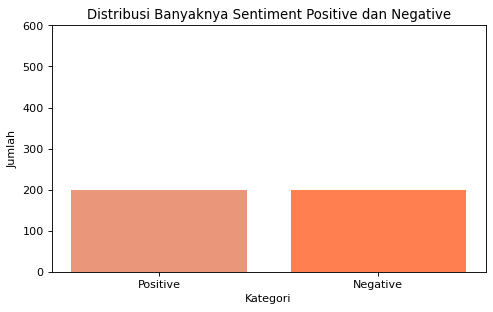

In [9]:
height = data['sentiment'].value_counts()
Sentiments = ('Positive', 'Negative')
y_pos = np.arange(len(Sentiments))

plt.figure(figsize=(7,4), dpi=80)
plt.ylim(0,600)
plt.title('Distribusi Banyaknya Sentiment Positive dan Negative')
plt.xlabel('Kategori')
plt.ylabel('Jumlah')
plt.bar(y_pos, height, color=['darksalmon', 'coral'])
plt.xticks(y_pos, Sentiments)
plt.show()

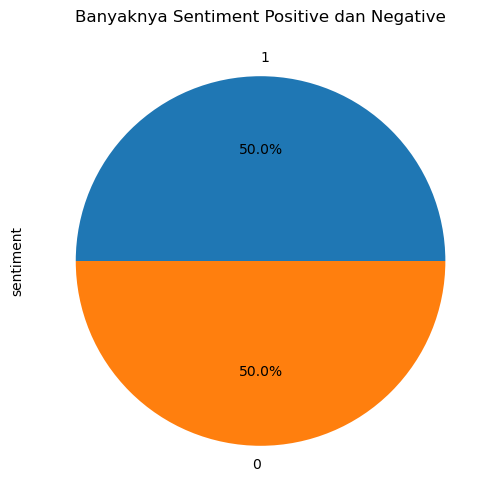

In [10]:
height = data['sentiment']

for i in height:
    plt.figure(figsize=(15,6))
    data['sentiment'].value_counts().plot(kind='pie',autopct='%1.1f%%')
    plt.title('Banyaknya Sentiment Positive dan Negative')
    plt.show()
    break

Bar plot dan pie plot diatas merupakan visualisasi data, dapat terlihat dengan jelas kedua sentiment memiliki jumlah/distribusi yang sama. Dengan angka '1' pada pie plot tersebut merupakan sentiment positive dan angka '0' merupakan sentiment negative.

## Data Preprocessing

### Case Folding

In [11]:
def case_folding(text):
    # Mengubah teks menjadi lower case
    text = text.lower()   
    # Menghapus URL
    text = re.sub(r"https?://\S+|www\.\S+", "",  text)
    # Menghapus angka
    text = re.sub(r"[-+]?[0-9]+", "", text)
    # Menghapus karakter tanda baca
    text = re.sub(r"[^\w\s]", "", text)
    # Menghapus whitespace leading dan trailing
    text = text.strip()
    # Menghapus hashtag
    text = re.sub(r"#\S+", "", text)
    # Menghapus mention
    text = re.sub(r"@\S+", "", text)
    return text

### Normalization

In [12]:
kamus = pd.read_excel('kamus_singkatan.xlsx')
kamus.head()

,aamiin,amin
0,adek,adik
1,adlh,adalah
2,aer,air
3,aiskrim,es krim
4,aj,saja


In [13]:
kamus.columns =['singkatan', 'hasil']
kamus.head()

,singkatan,hasil
0,adek,adik
1,adlh,adalah
2,aer,air
3,aiskrim,es krim
4,aj,saja


In [37]:
def text_normalize(text):
    text = ' '.join([kamus[kamus['singkatan'] == word]['hasil'].values[0] if (kamus['singkatan'] == word).any() 
                     else word for word in text.split()])
    text = str.lower(text)
    return text

### Filtering

In [15]:
stopwords_cyberbullying = stopwords.words('indonesian')
len(stopwords_cyberbullying)

758

In [17]:
stopwords_cyberbullying[:5]

['ada', 'adalah', 'adanya', 'adapun', 'agak']

In [18]:
more_stopword = ['username']
stopwords_cyberbullying = stopwords_cyberbullying + more_stopword

def remove_stopwords(text):
    clean_words = []
    text = text.split()
    for word in text:
        if word not in stopwords_cyberbullying:
            clean_words.append(word)
    return " ".join(clean_words)

### Stemming

In [19]:
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

factory = StemmerFactory()
stemmer = factory.create_stemmer()

# Buat fungsi untuk langkah stemming bahasa Indonesia
def stemming(text):
    text = stemmer.stem(text)
    return text

### Text Preprocessing Pipeline

In [20]:
def text_preprocessing(text):
    text = case_folding(text)
    text = text_normalize(text)
    text = remove_stopwords(text)
    text = stemming(text)
    return text

In [21]:
data['text'] = data['text'].apply(text_preprocessing)

## Feature Extraction

In [22]:
from sklearn.feature_extraction.text import TfidfVectorizer

vect =TfidfVectorizer(max_features=1000)
vect_text=vect.fit_transform(data['text'])

In [23]:
vect.vocabulary_

{'tolol': 953,
 'hubung': 338,
 'nya': 601,
 'pakai': 666,
 'hijab': 333,
 'bilang': 184,
 'panas': 668,
 'otak': 656,
 'sih': 892,
 'ya': 990,
 'nulis': 594,
 'komentar': 433,
 'bain': 91,
 'balikanhadewwntar': 103,
 'tinggal': 949,
 'nyalahin': 609,
 'tuh': 960,
 'oon': 640,
 'kemarin': 414,
 'mbak': 511,
 'kya': 445,
 'abege': 3,
 'ato': 47,
 'cari': 210,
 'sensasi': 883,
 'biar': 179,
 'top': 957,
 'ertong': 275,
 'kualitas': 438,
 'att': 48,
 'anak': 31,
 'kasihan': 403,
 'psikis': 756,
 'depan': 243,
 'orang': 647,
 'anda': 33,
 'benci': 159,
 'gimana': 297,
 'asa': 42,
 'nama': 551,
 'manusia': 496,
 'suka': 913,
 'haters': 325,
 'permpuan': 690,
 'utama': 977,
 'purutky': 765,
 'artis': 41,
 'ja': 361,
 'tinggalin': 950,
 'laki': 451,
 'mikir': 524,
 'kali': 395,
 'perempuan': 687,
 'urus': 975,
 'becus': 137,
 'mending': 518,
 'didik': 250,
 'biasa': 180,
 'balajaer': 99,
 'nyampah': 613,
 'instagram': 352,
 'bikin': 183,
 'caption': 209,
 'heboh': 328,
 'asik': 44,
 'lagu': 4

In [24]:
x1 = vect.transform(data['text']).toarray()
data_tabular_tf_idf= pd.DataFrame(x1,columns=vect.get_feature_names())
data_tabular_tf_idf

,aamiin,abal,abang,abege,abis,acara,aduh,agama,agnes,agus,...,ya,yaa,yaaa,yaampun,yaelah,yah,yes,you,youtube,zaman
0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.125127,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.294618,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
396,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
397,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
398,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Train and Test Split

In [25]:
from sklearn.model_selection import train_test_split

data_train, data_test = train_test_split(data, test_size=0.2, random_state=42)
data_val, data_test = train_test_split(data_test, test_size=0.5, random_state=42)

print("Train Data Size: ", len(data_train))
print("Validation Data Size: ", len(data_val))
print("Test Data Size: ", len(data_test))

Train Data Size:  320
Validation Data Size:  40
Test Data Size:  40


## Load Tokenizer

In [26]:
PRE_TRAINED_MODEL = 'indobenchmark/indobert-base-p2'

In [27]:
from transformers import BertTokenizer

bert_tokenizer = BertTokenizer.from_pretrained(PRE_TRAINED_MODEL)

In [76]:
vocabulary = bert_tokenizer.get_vocab()

print('Panjang vocabulary:', len(vocabulary))

Panjang vocabulary: 30521


## Memilih Panjang Sequence

Text(0.5, 0, 'Token count')

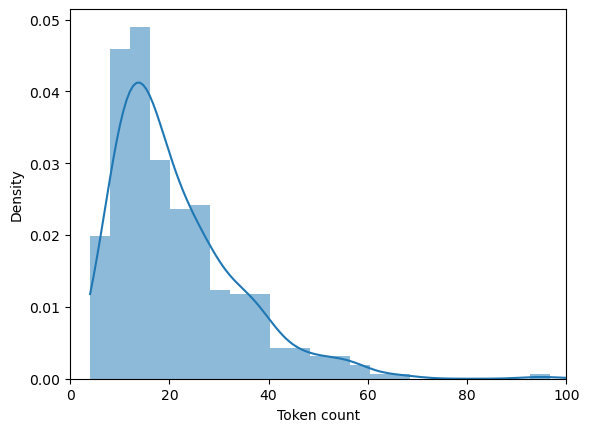

In [29]:
token_lens = []

for txt in data.text:
    tokens = bert_tokenizer.encode(txt)
    token_lens.append(len(tokens))

sns.histplot(token_lens, kde=True, stat='density', linewidth=0)
plt.xlim([0, 100]);
plt.xlabel('Token count')

In [30]:
MAX_LEN = 80

Dari plot diatas, saya memilih maximal lenght nya adalah 80 karena pada data selanjutnya tidak dominan atau density-nya sangat kecil.

### Formatting

In [31]:
def encode_sentence(sent):
    return bert_tokenizer.encode_plus(
        sent,
        add_special_tokens = True,
        padding = 'max_length',
        truncation = 'longest_first',
        max_length = MAX_LEN,
        return_attention_mask = True,
        return_token_type_ids=True
    )

In [32]:
def map_example_to_dict(input_ids, attention_masks, token_type_ids, label):
    return {
        "input_ids": input_ids,
        "attention_mask": attention_masks,
        "token_type_ids": token_type_ids,
    }, label

In [33]:
def encode(ds, limit=-1):
    input_ids_list = []
    attention_mask_list = []
    token_type_ids_list = []
    label_list = []

    for index, row in ds.iterrows():
        if limit > 0 and index >= limit:
            break

        input_ids, attention_mask, token_type_ids = encode_sentence(row["text"])["input_ids"], \
                                                    encode_sentence(row["text"])["attention_mask"], \
                                                    encode_sentence(row["text"])["token_type_ids"]
        label = row["sentiment"]

        input_ids_list.append(input_ids)
        attention_mask_list.append(attention_mask)
        token_type_ids_list.append(token_type_ids)
        label_list.append(label)

    return tf.data.Dataset.from_tensor_slices((
        input_ids_list,
        attention_mask_list,
        token_type_ids_list,
        label_list
    )).map(map_example_to_dict)

In [34]:
EPOCHS = 5
BATCH_SIZE = 32
LEARNING_RATE = 1e-5

In [35]:
train_encoded = encode(data_train).shuffle(42).batch(BATCH_SIZE)
test_encoded = encode(data_test).batch(BATCH_SIZE)
val_encoded = encode(data_val).batch(BATCH_SIZE)

## Model

In [36]:
bert_model = TFBertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL, num_labels=2)

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [38]:
optimizer = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')

bert_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

## Fine Turning

In [39]:
history = bert_model.fit(train_encoded, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_data=val_encoded)

Epoch 1/5
10/10 [==============================] - 317s 27s/step - loss: 0.6766 - accuracy: 0.5781 - val_loss: 0.5616 - val_accuracy: 0.8750
Epoch 2/5
10/10 [==============================] - 275s 28s/step - loss: 0.4740 - accuracy: 0.8625 - val_loss: 0.3673 - val_accuracy: 0.9250
Epoch 3/5
10/10 [==============================] - 272s 27s/step - loss: 0.2703 - accuracy: 0.9344 - val_loss: 0.2734 - val_accuracy: 0.9250
Epoch 4/5
10/10 [==============================] - 283s 28s/step - loss: 0.1453 - accuracy: 0.9563 - val_loss: 0.2379 - val_accuracy: 0.9000
Epoch 5/5
10/10 [==============================] - 283s 28s/step - loss: 0.0723 - accuracy: 0.9844 - val_loss: 0.2048 - val_accuracy: 0.9250


In [40]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string])
    plt.xlabel('Epochs')
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

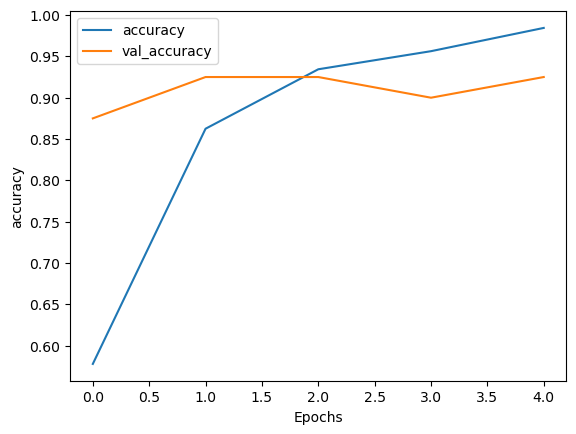

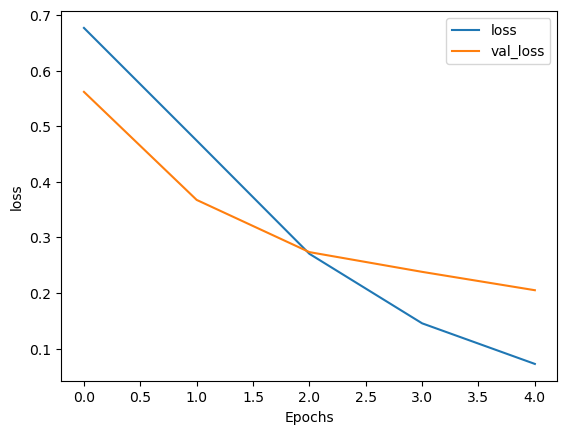

In [41]:
plot_graphs(history, 'accuracy')
plot_graphs(history, 'loss')

In [42]:
print('\nEpoch No.  Train Accuracy  Train Loss      Val Accuracy    Val Loss')
for i in range(EPOCHS):
    print('{:8d} {:10f} \t {:10f} \t {:10f} \t {:10f}'.format(i + 1, history.history['accuracy'][i], history.history['loss'][i], history.history['val_accuracy'][i], history.history['val_loss'][i]))


Epoch No.  Train Accuracy  Train Loss      Val Accuracy    Val Loss
       1   0.578125 	   0.676587 	   0.875000 	   0.561577
       2   0.862500 	   0.473993 	   0.925000 	   0.367253
       3   0.934375 	   0.270312 	   0.925000 	   0.273355
       4   0.956250 	   0.145281 	   0.900000 	   0.237856
       5   0.984375 	   0.072272 	   0.925000 	   0.204834


Berikut merupakan perubahan Train Accuracy, Train Loss, Validation Accuracy, Validation Loss pada proses Fine Turning. 

In [43]:
bert_model.save_weights('bert-model.h5')

## Evaluate

In [44]:
score = bert_model.evaluate(test_encoded)

print("Test Accuracy:", score[1])

2/2 [==============================] - 8s 2s/step - loss: 0.1254 - accuracy: 0.9500
Test Accuracy: 0.949999988079071


In [45]:
predicted_raw = bert_model.predict(test_encoded)

2/2 [==============================] - 17s 2s/step


In [46]:
y_pred = np.argmax(predicted_raw['logits'], axis=1)
y_true = np.array(data_test['sentiment'])

In [49]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_true, y_pred)

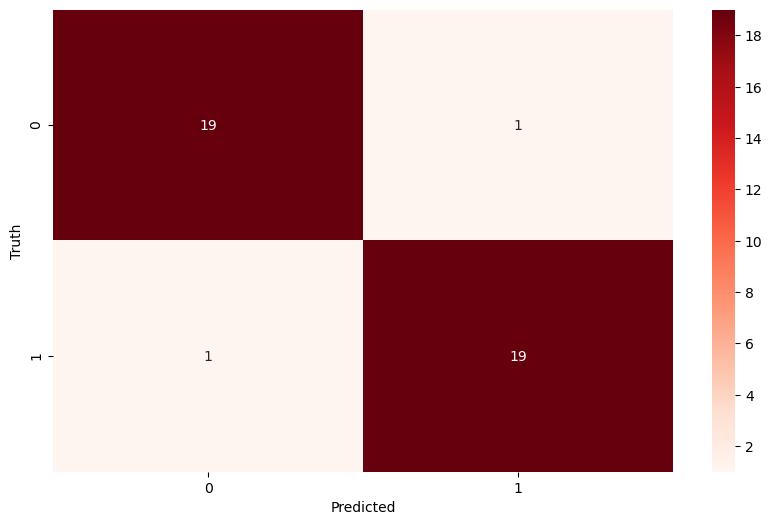

In [50]:
plt.figure(figsize=(10,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Reds')
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.show()

In [51]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

accuracy_score(y_true, y_pred)

0.95

In [52]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95        20
           1       0.95      0.95      0.95        20

    accuracy                           0.95        40
   macro avg       0.95      0.95      0.95        40
weighted avg       0.95      0.95      0.95        40



Setelah dilakukan evaluasi, diperoleh accuracy pada model Fine Turning tersebut adalah 95% yang mana model tersebut memiliki accuracy yang cukup tinggi.

## Predict

In [53]:
bert_load_model = TFBertForSequenceClassification.from_pretrained(PRE_TRAINED_MODEL, num_labels=2)
bert_load_model.load_weights('bert-model.h5')

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [70]:
input_text = input('Masukan komentar:')

Masukan komentar:suaranya bagus deh


In [71]:
input_text_tokenized = bert_tokenizer.encode(input_text,
                                             truncation=True,
                                             padding='max_length',
                                             return_tensors='tf')

In [72]:
bert_predict = bert_load_model(input_text_tokenized)          
bert_output = tf.nn.softmax(bert_predict[0], axis=-1)         

In [73]:
labels = ["negative", "positive"]
label = tf.argmax(bert_output, axis=1)
label = label.numpy()

In [74]:
print(input_text, ': memiliki sentiment', labels[label[0]])

suaranya bagus deh : memiliki sentiment positive


Dari proses predict tersebut diperoleh bahwa prediksi yang dilakukan pada model sudah benar apabila user melakukan input dengan komentar jelek maka sentimentnya negative dan apabila user melakukan input dengan komentar baik maka sentimentnya positive.

## Deployment

In [68]:
import gradio as gr

labels = ["negative", "positive"]

def predict(comment):
    input_ids, attention_mask, token_type_ids = encode_sentence(comment)["input_ids"], \
                                                encode_sentence(comment)["attention_mask"], \
                                                encode_sentence(comment)["token_type_ids"]
    input_ids = tf.expand_dims(input_ids, 0)
    attention_mask = tf.expand_dims(attention_mask, 0)
    token_type_ids = tf.expand_dims(token_type_ids, 0)

    outputs = bert_model([input_ids, attention_mask, token_type_ids])
    return labels[np.argmax(tf.nn.softmax(outputs[0], axis=1).numpy()[0])]

inputs = gr.inputs.Textbox(lines=5, placeholder="input text here")
outputs = gr.outputs.Label(num_top_classes=2)

gr.Interface(
    fn=predict,
    inputs=inputs,
    outputs=outputs,
    title="Sentiment Analysis",
    description="Sentiment Analysis using BERT Fine Tuning for Sequence Classification"
).launch()

Running on local URL:  http://127.0.0.1:7867

To create a public link, set `share=True` in `launch()`.


(<gradio.routes.App at 0x13994ec0460>, 'http://127.0.0.1:7867/', None)